In [1]:
# Required Packages
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima

# Plots

import seaborn as sns
import matplotlib.pyplot as plt

# sns setting
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":14,"axes.labelsize":12})
sns.set_style("whitegrid")

# plt setting
plt.style.use('seaborn-whitegrid')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Industrial Production: Electric and Gas Utilities

In this article, we use a dataset from [Fred Economic Data](fred.stlouisfed.org/). In particular, we use Industrial Production (electric and gas utilities) from 1939-01-01 until Now (the last available dataset). This dataset can be obtained [here](https://fred.stlouisfed.org/series/IPG2211A2N).

#### Table of contents
* [Notes on the Dataset](#Notes-on-the-Dataset)
* [Train and Set Tests](#Train-and-Set-Tests)
* [Predications](#Predications)

## Notes on the Dataset
* **Source**: Board of Governors of the Federal Reserve System (US)  Release: G.17 Industrial Production and Capacity Utilization  
* **Units**:  Index 2012=100, Not Seasonally Adjusted
* **Frequency**:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

* **NAICS** = 2211,2
* **Source Code**: IP.G2211A2.N
* **Suggested Citation**:
Board of Governors of the Federal Reserve System (US), Industrial Production: Electric and gas utilities [IPG2211A2N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPG2211A2N, December 5, 2019.

#### Loading Dataset

In [2]:
#  Industrial Production: Electric and gas utilities
Data = pd.read_csv('Data/IPG2211A2N.csv').reset_index(drop = False)
Data = Data.rename(columns={'DATE': 'Date', 'IPG2211A2N': 'Index'})
Data = Data.set_index('Date').drop(columns = ['index'])
# Converting the index column values to datetime
Data.index = pd.to_datetime(Data.index)
Data.tail(12).T

Date,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01
Index,103.575,112.9498,123.7687,112.9837,106.6593,88.6631,91.9852,98.4547,113.0792,111.2541,102.151,91.5944


In [3]:
print ('The Number of NaN values = %i' % Data[pd.isnull(Data.Index)].sum()[0])

The Number of NaN values = 0


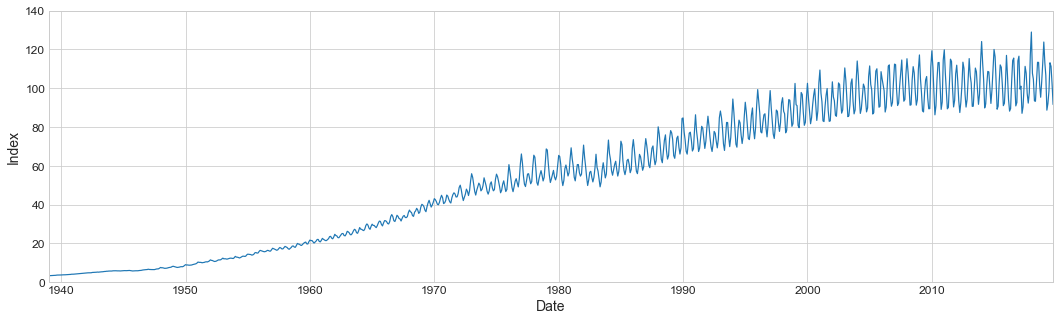

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(18, 5), sharex=False)
_ = ax = sns.lineplot(data = Data, legend = False)
_ = ax.set_xlabel('Date')
_ = ax.set_ylabel('Index')
_ = ax.set_xlim([Data.index[0],Data.index[-1]])
_ = ax.set_ylim([0,140])

First, we can use **seasonal decompose** function (read more about this function [here](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) to analyze the **Data**.

In [5]:
Results = seasonal_decompose(Data, model='multiplicative')

In [6]:
Table = pd.concat([Results.observed, Results.trend, Results.seasonal, Results.resid], axis=1)
Table.columns = ['Observed data', 'The estimated trend component',
                 'The estimated seasonal component','The estimated residuals']
Table.tail()

,Observed data,The estimated trend component,The estimated seasonal component,The estimated residuals
Date,,,,
2019-06-01,98.4547,NaN,0.975695,NaN
2019-07-01,113.0792,NaN,1.028045,NaN
2019-08-01,111.2541,NaN,1.039913,NaN
2019-09-01,102.1510,NaN,0.986146,NaN
2019-10-01,91.5944,NaN,0.937347,NaN


Plots

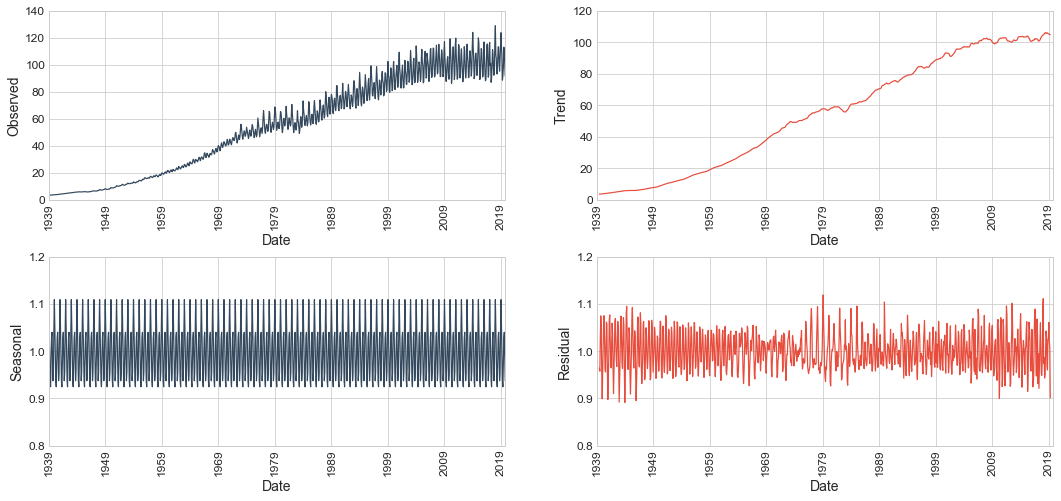

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 8), sharex=False)
# Observed
Results.observed.plot(rot=90,ax=ax[0,0], color='#34495e', legend=False)
_ = ax[0,0].set_xlabel('Date')
_ = ax[0,0].set_ylabel('Observed')
_ = ax[0,0].set_ylim([0,140])
# Trend
Results.trend.plot(rot=90,ax=ax[0,1], color='#e74c3c', legend=False)
_ = ax[0,1].set_xlabel('Date')
_ = ax[0,1].set_ylabel('Trend')
_ = ax[0,1].set_ylim([0,120])
# Seasonal
Results.seasonal.plot(rot=90,ax=ax[1,0], color='#34495e', legend=False)
_ = ax[1,0].set_xlabel('Date')
_ = ax[1,0].set_ylabel('Seasonal')
_ = ax[1,0].set_ylim([0.8,1.2])
# Seasonal
Results.resid.plot(rot=90,ax=ax[1,1], color='#e74c3c', legend=False)
_ = ax[1,1].set_xlabel('Date')
_ = ax[1,1].set_ylabel('Residual')
_ = ax[1,1].set_ylim([0.8,1.2])
plt.subplots_adjust(hspace=0.3)

Furthermore, here we use the **auto_arima** function that Automatically discovers the optimal order for an [ARIMA model](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) for the sake of predictions. Ideally, we are looking for a model that fits the data and has the lost AIC score, AIC stands for [Akaike information criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion). the AIC score gives provides a way to measure the goodness-of-fit of your model.

In [8]:
Model = auto_arima(Data, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                   start_P=0, seasonal=True, d=1, D=1, trace=True,
                   error_action='ignore',  suppress_warnings=True, stepwise=True) 

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3832.693, BIC=3857.012, Fit time=5.770 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=4349.442, BIC=4359.170, Fit time=0.094 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=4180.073, BIC=4199.528, Fit time=1.192 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3955.288, BIC=3974.744, Fit time=1.644 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=3832.014, BIC=3861.196, Fit time=5.304 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=4012.370, BIC=4036.689, Fit time=3.858 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=3825.326, BIC=3859.373, Fit time=36.267 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=3947.443, BIC=3976.626, Fit time=9.474 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=3823.511, BIC=3862.421, Fit time=38.068 seconds
Fit ARIMA: order=(2, 1, 0)

In [9]:
print('The AIC score = %.4f' % Model.aic())

The AIC score = 3781.1033


## Train and Set Tests

We can simply consider the data from the current year as the Test set and the rest of the data as the train set. That is

In [10]:
C = "%i-12-01" % (Data.index[-1].year -1)
# Train Set
Train = Data.loc[:C]
del C
Train.tail(12).T

Date,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01
Index,128.9071,107.6711,104.5716,93.4491,93.2405,103.3083,113.3178,113.2758,101.5656,95.3203,103.575,112.9498


In [11]:
C = "%i-01-01" % (Data.index[-1].year)
# Test Set
Test = Data.loc[C:]
del C
Test.tail(12).T

Date,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01
Index,123.7687,112.9837,106.6593,88.6631,91.9852,98.4547,113.0792,111.2541,102.151,91.5944


Now

In [12]:
Model.fit(Train)

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(3, 1, 3),
      out_of_sample_size=0, scoring='mse', scoring_args=None,
      seasonal_order=(2, 1, 2, 12), solver='lbfgs', start_params=None,
      suppress_warnings=True, transparams=True, trend=None,
      with_intercept=True)

## Predications

In [13]:
Temp = Model.predict(n_periods = len(Test))
Predications = pd.DataFrame(Temp, index = Test.index, columns=['Predications'])
del Temp
Predications.T

Date,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01
Predications,124.486532,111.472888,104.43886,92.761198,94.018346,104.612509,114.611832,113.73472,103.44054,95.060847


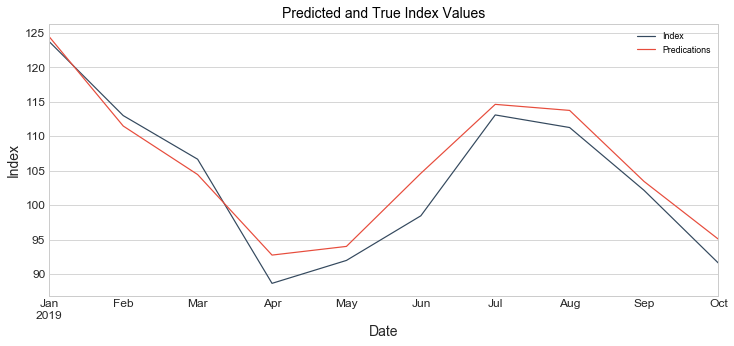

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5), sharex=False)
# Observed
_ = Test.plot(rot=0, ax=ax, color='#34495e')
_ = Predications.plot(rot=0, ax=ax, color='#e74c3c')
_ = ax.set_title('Predicted and True Index Values')
_ = ax.set_ylabel('Index')